In [ ]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [2]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
import submodules.data_filter as _df
import diffusion_pipline.data_processing as dproc
import diffusion_pipline.model as md
import submodules.cleaned_file_parser as cfp


In [3]:
# observation and action dimensions corrsponding to
# the output of PushTEnv
# obs_dim = 25
# action_dim = 13
type = 'VVSS'
obs_dim = 45
action_dim = 12
# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
target_fps = 120.0

action_item = ['chisel', 'gripper']
obs_item = ['battery']

# create network object
noise_pred_net = md.ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.651803e+07


In [4]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "no_sync/data_chisel_task/2-cleaned_interpolation_with_offset/offset_interpolated_training_traj/"

# Load data
# Load data
dict_of_df_rigid = {}
dict_of_df_marker = {}


for file in os.listdir(base_path):

    if file.endswith(".csv"):
        path_name = base_path + file
        data = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker[file] = data.get_marker_Txyz()
        data_time = data.get_time().astype(float)
        data_state_dict = data.get_rigid_TxyzRxyz()

        # use the time and state data to get the velocity data
        data_velocity_dict = {}
        for key in data_state_dict.keys():
            if key != 'battery':
                data_velocity = []
                for i in range(0, len(data_time)-1):
                    data_velocity.append((data_state_dict[key][i + 1] - data_state_dict[key][i]) / (data_time[i + 1] - data_time[i]))
                velocity_data = pd.DataFrame(data_velocity, columns = [f'{key}_X', f'{key}_Y', f'{key}_Z', f'{key}_x', f'{key}_y', f'{key}_z'])
                filtered_velocity = _df.apply_savgol_filter(velocity_data, window_size = 5, polyorder = 3, time_frame= False)
                data_velocity_dict[key] = filtered_velocity.values
            else:
                data_velocity_dict[key] = data_state_dict[key]

        dict_of_df_rigid[file] = data_velocity_dict


item_name = data.rigid_bodies
marker_name = data.markers

if len(dict_of_df_rigid) == len(dict_of_df_marker):

    rigiddataset, index = _df.episode_combiner(dict_of_df_rigid, item_name)
    markerdataset, _ = _df.episode_combiner(dict_of_df_marker, marker_name)
    print(index[action_item[0]])


#### if you don't want battery info then just do obs_item = None abd also do clear all outputs and restart the kernal before that and satrt from the top 

dataset = dproc.TaskStateDataset(Rigiddataset= rigiddataset, Velocitydataset= None, Markerdataset= markerdataset, index=index[action_item[0]], 
                                 action_item = action_item, obs_item = obs_item,
                                 marker_item= marker_name,
                                 pred_horizon=pred_horizon,
                                 obs_horizon=obs_horizon,
                                 action_horizon=action_horizon)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

[1090, 2309, 3706, 4606, 5620, 7270, 8210, 9424, 10366, 11041, 12227, 13068, 14115, 15639, 16657, 17672, 18694, 20002, 20831, 21776, 22609, 23786, 24749, 25578, 27025, 28136, 28962, 29743, 30575, 32330, 33534, 34697, 35648, 36888, 37900, 38926, 40317, 41694, 42706, 43845, 45386, 46258, 47223, 48098, 49064, 49903, 50809, 52246, 53907, 54860, 56890, 57935, 58994, 59920, 60771, 62118, 63086, 64314, 65209, 67502, 68586, 69723, 70573, 71503, 72655, 73748, 74616, 75587, 77021, 77941, 78862, 80285, 81148, 82180, 83060, 84011, 84967, 85992, 86759, 87685, 88617, 89641, 90500, 91427, 92324, 93591, 94835, 95614, 96555, 97839, 99021, 100103, 101367, 102511, 103854, 104704, 105669, 106852, 107667, 108688, 109859, 110557, 111535, 113111, 114101, 115048, 115959, 116935, 118264, 119159, 120035, 121242, 122138, 123008, 123987, 125141, 126706, 127616, 128484]
batch['obs'].shape: torch.Size([256, 2, 45])
batch['action'].shape torch.Size([256, 16, 12])


In [5]:
key

'gripper'

In [6]:
file

'cap_059_cleaned_x_-0.15334246648352792_y_0.2785214174020794_z_-0.018892243796625165_offset.csv'

In [7]:
data_velocity_dict['chisel'][0]

array([ 0.00450717,  0.01029194, -0.02433098,  0.09444591,  0.00769316,
       -0.15173119])

In [8]:
data_velocity_dict['chisel'][1]

array([ 0.00047834,  0.008623  , -0.02156828,  0.07085104, -0.01520216,
       -0.10561395])

In [9]:
data_velocity[0]

array([ 0.0295349 ,  0.04363964, -0.01197962,  0.04066192, -0.11170285,
       -0.0033014 ])

In [10]:
data_velocity[1]

array([ 0.02254113,  0.03117133, -0.0131181 ,  0.01684457, -0.06729084,
       -0.02042156])

In [11]:
velocity_data

,gripper_X,gripper_Y,gripper_Z,gripper_x,gripper_y,gripper_z
0,0.029535,0.043640,-0.011980,0.040662,-0.111703,-0.003301
1,0.022541,0.031171,-0.013118,0.016845,-0.067291,-0.020422
2,0.028913,0.038027,-0.021218,0.004810,-0.069684,-0.040685
3,0.051402,0.065126,-0.044910,-0.020955,-0.102452,-0.086536
4,0.054185,0.066864,-0.054771,-0.054735,-0.092023,-0.095751
...,...,...,...,...,...,...
863,0.001255,-0.000025,-0.000587,-0.020297,0.022833,-0.023729
864,0.001911,-0.000113,0.000116,-0.018643,0.014303,-0.007929
865,0.002511,-0.000321,0.000968,-0.017260,0.002509,0.012509
866,0.003056,-0.000648,0.001971,-0.016147,-0.012552,0.037586


In [12]:
filtered_velocity

,gripper_X,gripper_Y,gripper_Z,gripper_x,gripper_y,gripper_z
0,0.029535,0.043640,-0.011980,0.040662,-0.111703,-0.003301
1,0.022178,0.030672,-0.012981,0.016191,-0.066211,-0.019871
2,0.030364,0.040024,-0.021766,0.007426,-0.074004,-0.042888
3,0.049225,0.062131,-0.044089,-0.024879,-0.095972,-0.083231
4,0.048899,0.060587,-0.048481,-0.045283,-0.085220,-0.085607
...,...,...,...,...,...,...
863,0.001255,-0.000025,-0.000587,-0.020297,0.022833,-0.023730
864,0.001911,-0.000113,0.000116,-0.018643,0.014303,-0.007929
865,0.002511,-0.000321,0.000968,-0.017260,0.002508,0.012510
866,0.003056,-0.000648,0.001971,-0.016146,-0.012551,0.037586


In [13]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs =200
checkpoint_dir = 'no_sync/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_interval = 3600
last_checkpoint_time = time.time()
# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    epoch_loss = []
    batch_loss_per_epoch = []

    for epoch_idx in tglobal:
        batch_loss = []
        batch_noise = []
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:

            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs']
                naction = nbatch['action']
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1).float().to(device)
                # print(obs_cond.type())

                # sample noise to add to actions
                # noise = torch.randn(naction.shape, device=device)
                noise = torch.randn(naction.shape)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,)
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)
                
                noise = noise.to(device)
                
                timesteps = timesteps.to(device)

                # print(noisy_actions.type())
                noisy_actions = noisy_actions.type(torch.FloatTensor).to(device)
                # print(noisy_actions.type())

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)
                
                batch_noise.append(noise_pred)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)
                # print(ema.state_dict)

                # logging
                loss_cpu = loss.item()
                batch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # save checkpoint
        # went to the emma model library and added state_dict to the model
        current_time = time.time()
        if current_time - last_checkpoint_time > checkpoint_interval:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
            torch.save({
                        'epoch': epoch_idx,
                        'model_state_dict': noise_pred_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': lr_scheduler.state_dict(),
                        'ema_state_dict': ema.state_dict(),
                        'len_dataloader': len(dataloader),
                        'dataset_stats': dataset.stats,
                        'num_epochs': num_epochs,
                        'obs_dim': obs_dim,
                        'action_dim': action_dim,
                        'pred_horizon': pred_horizon,
                        'obs_horizon': obs_horizon,
                        'action_horizon': action_horizon,
                        'target_fps': target_fps,
                        'action_item': action_item,
                        'obs_item': obs_item,
                        'marker_item': marker_name,
                    }, checkpoint_path)
            last_checkpoint_time = current_time
            
        tglobal.set_postfix(loss=np.mean(batch_loss))
        epoch_loss.append(np.mean(batch_loss))
        batch_loss_per_epoch.append(batch_loss)

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net

checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{type}_epoch_{epoch_idx}.pth')
torch.save({
    'epoch': epoch_idx,
    'model_state_dict': noise_pred_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'ema_state_dict': ema.state_dict(),
    'len_dataloader': len(dataloader),
    'dataset_stats': dataset.stats,
    'num_epochs': num_epochs,
    'obs_dim': obs_dim,
    'action_dim': action_dim,
    'pred_horizon': pred_horizon,
    'obs_horizon': obs_horizon,
    'action_horizon': action_horizon,
    'target_fps': target_fps,
    'action_item': action_item,
    'obs_item': obs_item,
    'marker_item': marker_name,
}, checkpoint_path)
print(f'Checkpoint saved at epoch {epoch_idx}')

Epoch:  35%|███▌      | 70/200 [1:00:10<1:52:00, 51.69s/it, loss=0.00254]

Checkpoint saved at epoch 69


Epoch:  70%|███████   | 140/200 [2:00:12<51:34, 51.57s/it, loss=0.00106]  

Checkpoint saved at epoch 139


Epoch: 100%|██████████| 200/200 [2:51:39<00:00, 51.50s/it, loss=0.000591]


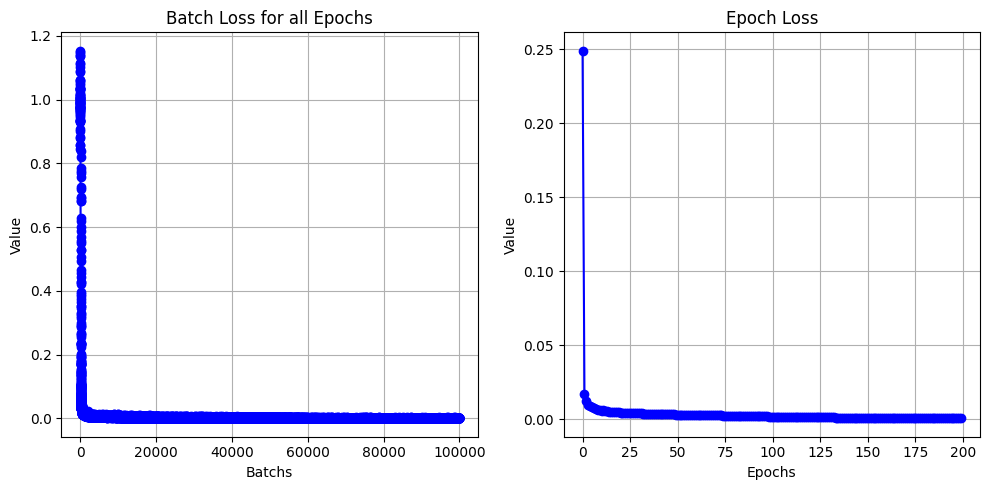

In [14]:
# Create a figure and axis
import matplotlib.pyplot as plt

flatten_loss = np.array(batch_loss_per_epoch)

flatten_loss = flatten_loss.flatten()
# Define subplots correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for the first subplot (ax1)
ax1.plot(flatten_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the first subplot (ax1)
ax1.set_xlabel('Batchs')
ax1.set_ylabel('Value')
ax1.set_title('Batch Loss for all Epochs')
ax1.grid(True)
# ax1.legend()

# Plot for the second subplot (ax2)
ax2.plot(epoch_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the second subplot (ax2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Epoch Loss')
ax2.grid(True)
# ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

####  Test dataset evaluation

In [16]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "no_sync/data_chisel_task/2-cleaned_interpolation_with_offset/offset_interpolated_test_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker_test[file] = data_test.get_marker_Txyz()
        data_time = data_test.get_time().astype(float)
        data_state_dict = data_test.get_rigid_TxyzRxyz()

        # use the time and state data to get the velocity data
        data_velocity_dict = {}
        for key in data_state_dict.keys():
            if key != 'battery':
                data_velocity_dict[key] = np.zeros_like(data_state_dict[key])
                for i in range(0, len(data_time) - 1):
                    data_velocity_dict[key][i] = (data_state_dict[key][i + 1] - data_state_dict[key][i]) / (data_time[i + 1] - data_time[i])
                velocity_data = pd.DataFrame(data_velocity_dict[key], columns = [f'{key}_X', f'{key}_Y', f'{key}_Z', f'{key}_x', f'{key}_y', f'{key}_z'])
                filtered_velocity = _df.apply_savgol_filter(velocity_data, window_size = 15, polyorder = 3, time_frame= False)
                data_velocity_dict[key] = filtered_velocity.values
            else:
                data_velocity_dict[key] = data_state_dict[key]

        dict_of_df_rigid_test[file] = data_velocity_dict


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)

indexes = index_test[action_item[0]]
action = []
obs = []
for i in range(indexes[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)
    
# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through episode_ends and slice action and obs accordingly
for index in indexes:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [18]:
len(splits_obs[0])

846

In [19]:
import collections

trajectories = {}
losses_per_traj = {}
for j in range(len(indexes)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            # print(len(naction[0]))
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            traj.extend(action)
            losses = []
                
            for i in range(len(action)):
                # loss
            # print("Action_pred -",action[0])
            # print("Action_orignal -",actions_test[0])
            # print("Obs_added without pred-",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                action_last = list(action[i])
                # print("Action_last ---",action_last)
                com_obs_part = list(com_obs[i][12:])
                # print("Obs to add", com_obs_part)
                # Concatenating prediction to the obs lists
                com_obs[i] = action_last + com_obs_part
                # print("Obs_added with pred -",com_obs[i])
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            # com_obs = com_obs[1:]
            # actions_test = actions_test[1:]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories[f"{name[j]}"] = traj

Eval: 100%|█████████▉| 928/932 [01:19<00:00, 11.61it/s, loss=0.00853]


In [21]:
lr_scheduler.state_dict()

{'base_lrs': [0.0001],
 'last_epoch': 99800,
 'verbose': False,
 '_step_count': 99801,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0],
 'lr_lambdas': [None]}

In [23]:
print(ema.state_dict())

{'decay': 0.9999, 'min_decay': 0.0, 'optimization_step': 99800, 'update_after_step': 0, 'use_ema_warmup': False, 'inv_gamma': 1.0, 'power': 0.75, 'shadow_params': [tensor([[[-0.0257, -0.0194, -0.0476, -0.0182,  0.0025],
         [-0.0223,  0.0277, -0.0176, -0.0001,  0.0041],
         [ 0.0222,  0.0457,  0.0284, -0.0087,  0.0012],
         ...,
         [ 0.0179,  0.0109,  0.0017, -0.0079,  0.0226],
         [ 0.0062, -0.0166, -0.0218, -0.0118, -0.0125],
         [-0.0211, -0.0018,  0.0194,  0.0129, -0.0015]],

        [[ 0.0163, -0.0066, -0.0102,  0.0015,  0.0097],
         [-0.0024,  0.0254, -0.0083,  0.0206,  0.0117],
         [-0.0085, -0.0101, -0.0045, -0.0006,  0.0262],
         ...,
         [-0.0151, -0.0206, -0.0047,  0.0113,  0.0241],
         [-0.0017,  0.0199,  0.0179, -0.0138, -0.0175],
         [ 0.0046,  0.0192,  0.0134,  0.0031,  0.0257]],

        [[ 0.0008, -0.0021, -0.0072, -0.0026, -0.0137],
         [ 0.0365,  0.0148,  0.0179, -0.0077, -0.0052],
         [ 0.0053,  

In [20]:
trajectories.keys()

dict_keys(['test_146_cleaned_x_0.14096537172423318_y_-0.23557708216841594_z_-0.0020245425118853716_offset.csv', '.~lock.test_147_cleaned_x_0.29517503564499276_y_-0.27719737935048877_z_0.04328177068656369_offset.csv#', 'test_134_cleaned_x_0.1356862451941565_y_-0.01953352181121243_z_0.02472300936740239_offset.csv', 'test_136_cleaned_x_0.013339221088756514_y_-0.15908913428544308_z_0.004476015539873465_offset.csv', 'test_150_cleaned_x_-0.04636982316456001_y_-0.04406156461143562_z_0.025624586255881487_offset.csv', 'test_131_cleaned_x_0.26201095918367595_y_-0.28169639422304527_z_-0.0029254899763002523_offset.csv', 'test_144_cleaned_x_-0.027008412295657813_y_-0.283512661712995_z_-0.00421141714737764_offset.csv', 'test_129_cleaned_x_-0.04013612801356209_y_-0.22672760495518585_z_-0.03153151095472171_offset.csv', 'test_148_cleaned_x_-0.12232136775585395_y_0.08294384316786174_z_0.009779209770707412_offset.csv', 'test_145_cleaned_x_-0.04871722258315703_y_-0.08034928428762544_z_0.000944893756643139

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('/home/cam/Documents/diffusion_policy_cam/no_sync/pred_comparison_july_22/pred_correct_method_velocity_chisel_gripper_battery(s)_marker/pred_trajectory_chisel_plots.pdf') as pdf:
    for index, key in enumerate(trajectories.keys()):

        # if index == 1:
        #     break

        x_coords = [item[3] for item in trajectories[key]]
        y_coords = [item[4] for item in trajectories[key]]
        z_coords = [item[5] for item in trajectories[key]]
        # on_off = [item[12] for item in trajectories[key]]

        fig = plt.figure(figsize=(18, 24),constrained_layout=True)
        
        # Add a global title for the figure
        # fig.suptitle(f'Comprehensive Plots for {result_dict[index]['Path'].split('/')[-1]}', fontsize=16, fontweight='bold')
        fig.suptitle(f'Comprehensive Plots for {key} - loss = {losses_per_traj[key]}', fontsize=16, fontweight='bold',y=0.998)
        # plt.subplots_adjust(top=0.9, hspace=0.4)

        # Plot XYZ coordinates
        plt.subplot(4, 2, 1)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Euler angles
        roll = [item[0] for item in trajectories[key]]
        pitch = [item[1] for item in trajectories[key]]
        yaw = [item[2] for item in trajectories[key]]

        plt.subplot(4, 2, 2)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities (Radians)')


        x_coords = [item[3] for item in splits_action[index]]
        y_coords = [item[4] for item in splits_action[index]]
        z_coords = [item[5] for item in splits_action[index]]
        # on_off = [item[12] for item in splits_action[index]]


        # Plot XYZ coordinates
        plt.subplot(4, 2, 3)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[0] for item in splits_action[index]]
        pitch = [item[1] for item in splits_action[index]]
        yaw = [item[2] for item in splits_action[index]]

        plt.subplot(4, 2, 4)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        x_coords = [item[9] for item in trajectories[key]]
        y_coords = [item[10] for item in trajectories[key]]
        z_coords = [item[11] for item in trajectories[key]]

        # Plot Euler vel
        plt.subplot(4, 2, 5)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in trajectories[key]]
        pitch = [item[7] for item in trajectories[key]]
        yaw = [item[8] for item in trajectories[key]]

        plt.subplot(4, 2, 6)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities ')


        x_coords = [item[9] for item in splits_action[index]]
        y_coords = [item[10] for item in splits_action[index]]
        z_coords = [item[11] for item in splits_action[index]]

        # Plot Euler vel
        plt.subplot(4, 2, 7)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in splits_action[index]]
        pitch = [item[7] for item in splits_action[index]]
        yaw = [item[8] for item in splits_action[index]]

        plt.subplot(4, 2, 8)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the figure with the global title
        plt.close(fig)
    # plt.show()

##### veloctiy to state conversion block and save back to state file

In [ ]:
import csv


for index, key in enumerate(trajectories.keys()):
    print(index)
    # if index == 1:
    #     break
    # Define the file path or name
    combined_list = []
    file_path = f'no_sync/data_chisel_task/visualization_for_datasets/2-cleaned_interpolation_with_offset/pred/6_VVSS/csvs/pred_correct_method_velocity_chisel_gripper_battery(s)_marker_state_files/pred_state_{key}'
    path_name = 'no_sync/data_chisel_task/2-cleaned_interpolation_with_offset/offset_interpolated_test_traj/' + key

    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params[save_type]['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    
    data_info = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)
    time_per_step = 1/data_info.fps
    start_pos = np.concatenate([data_info.get_rigid_TxyzRxyz()[obj][0] for obj in action_item]).tolist()

    min_length = min(len(trajectories[key]), len(splits_obs[index][11:]))
    initial_vel = np.zeros(len(start_pos))
    for x, y in zip(np.array(trajectories[key][:min_length]), np.array(splits_obs[index][:min_length])):
        traj_xyz = start_pos + (x*time_per_step)
        start_pos = traj_xyz
        # initial_vel = x
        combined_list.append(np.concatenate([traj_xyz, y[12:]]))

    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)


#### Save velocity pred files

In [ ]:
import csv


for index, key in enumerate(trajectories.keys()):
    print(index)
    # Define the file path or name
    file_path = f'no_sync/data_chisel_task/visualization_for_datasets/2-cleaned_interpolation_with_offset/pred/6_VVSS/csvs/pred_velocity_csv_test/pred_{key}'
    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params['Vel']['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)

#### Training Evaluation

In [ ]:
# create dataset from file
# path_name = "/home/cam/Downloads/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/diffusion_policy_cam/no_sync/data_chisel_task/2-cleaned_interpolation_with_offset/offset_interpolated_training_traj/"

# Load data
dict_of_df_rigid_test = {}
dict_of_df_marker_test = {}
name = []

# for file in os.listdir(base_path):
#     name.append(file)
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        name.append(file)
        path_name = base_path + file
        data_test = cfp.DataParser.from_euler_file(file_path = path_name, target_fps=target_fps, filter=True, window_size=15, polyorder=3)

        dict_of_df_marker_test[file] = data_test.get_marker_Txyz()
        data_time = data_test.get_time().astype(float)
        data_state_dict = data_test.get_rigid_TxyzRxyz()

        # use the time and state data to get the velocity data
        data_velocity_dict = {}
        for key in data_state_dict.keys():
            if key != 'battery':
                data_velocity_dict[key] = np.zeros_like(data_state_dict[key])
                for i in range(1, len(data_time)):
                    data_velocity_dict[key][i] = (data_state_dict[key][i] - data_state_dict[key][i-1]) / (data_time[i] - data_time[i-1])
                    velocity_data = pd.DataFrame(data_velocity_dict[key], columns = [f'{key}_X', f'{key}_Y', f'{key}_Z', f'{key}_x', f'{key}_y', f'{key}_z'])
                    filtered_velocity = _df.apply_savgol_filter(velocity_data, window_size = 15, polyorder = 3, time_frame= False)
                    data_velocity_dict[key] = filtered_velocity.values
            else:
                data_velocity_dict[key] = data_state_dict[key]

        dict_of_df_rigid_test[file] = data_velocity_dict


item_name_test = data_test.rigid_bodies
marker_name_test = data_test.markers

if len(dict_of_df_rigid_test) == len(dict_of_df_marker_test):

    rigiddataset_test, index_test = _df.episode_combiner(dict_of_df_rigid_test, item_name_test)
    markerdataset_test, _ = _df.episode_combiner(dict_of_df_marker_test, marker_name_test)
    
indexes = index_test[action_item[0]]
action = []
obs = []
for i in range(indexes[-1]):
    # a = []
    a = np.concatenate([rigiddataset_test[item][i] for item in action_item])
    # print(a)

    b = np.concatenate([rigiddataset_test[item][i] for item in action_item] + [rigiddataset_test[item][i] for item in obs_item] + [markerdataset_test[item][i] for item in marker_name_test])
    # print(b)
    
    action.append(a)
    obs.append(b)
    
# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)

# Initialize lists to store segmented data
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through episode_ends and slice action and obs accordingly
for index in indexes:
    splits_obs.append(obs[previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(action[previous_index:index + 1])
    previous_index = index + 1

In [ ]:
trajectories_train = {}
losses_per_traj = {}
for j in range(len(indexes)):
    # print(j)
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    loss_com = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = dproc.normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = dproc.unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # print(action[0])
            # print(actions_test[0])
            traj.extend(action)
            losses = []

            # if len(action) <= len(actions_test):
            #     lenths = len(action)

            # else :
            #     lenths = len(actions_test)
                
            for i in range(len(action)):
                # loss
                # print("Action_pred -",action[i])
                # print("Action_orignal -",actions_test[i])
                # print("Obs_added -",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
            loss_com.append(np.mean(losses).tolist())
    losses_per_traj[f"{name[j]}"] = np.nanmean(loss_com)
    trajectories_train[f"{name[j]}"] = traj

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('no_sync/data_chisel_task/visualization_for_datasets/2-cleaned_interpolation_with_offset/pred/6_VVSS/csvs/pred_velocity_csv_train/pred_trajectory_chisel_plots.pdf') as pdf:
    for index, key in enumerate(trajectories_train.keys()):

        # if index == 1:
        #     break

        x_coords = [item[3] for item in trajectories_train[key]]
        y_coords = [item[4] for item in trajectories_train[key]]
        z_coords = [item[5] for item in trajectories_train[key]]
        # on_off = [item[12] for item in trajectories[key]]

        fig = plt.figure(figsize=(18, 24),constrained_layout=True)
        
        # Add a global title for the figure
        # fig.suptitle(f'Comprehensive Plots for {result_dict[index]['Path'].split('/')[-1]}', fontsize=16, fontweight='bold')
        fig.suptitle(f'Comprehensive Plots for {key} - loss = {losses_per_traj[key]}', fontsize=16, fontweight='bold',y=0.998)
        # plt.subplots_adjust(top=0.9, hspace=0.4)

        # Plot XYZ coordinates
        plt.subplot(4, 2, 1)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Euler angles
        roll = [item[0] for item in trajectories_train[key]]
        pitch = [item[1] for item in trajectories_train[key]]
        yaw = [item[2] for item in trajectories_train[key]]

        plt.subplot(4, 2, 2)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Gripper- - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities (Radians)')


        x_coords = [item[3] for item in splits_action[index]]
        y_coords = [item[4] for item in splits_action[index]]
        z_coords = [item[5] for item in splits_action[index]]
        # on_off = [item[12] for item in splits_action[index]]


        # Plot XYZ coordinates
        plt.subplot(4, 2, 3)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        # plt.plot(range(len(on_off)), on_off, label='On-OFF', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[0] for item in splits_action[index]]
        pitch = [item[1] for item in splits_action[index]]
        yaw = [item[2] for item in splits_action[index]]

        plt.subplot(4, 2, 4)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Gripper - XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        x_coords = [item[9] for item in trajectories_train[key]]
        y_coords = [item[10] for item in trajectories_train[key]]
        z_coords = [item[11] for item in trajectories_train[key]]

        # Plot Euler vel
        plt.subplot(4, 2, 5)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in trajectories_train[key]]
        pitch = [item[7] for item in trajectories_train[key]]
        yaw = [item[8] for item in trajectories_train[key]]

        plt.subplot(4, 2, 6)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Pred Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities ')


        x_coords = [item[9] for item in splits_action[index]]
        y_coords = [item[10] for item in splits_action[index]]
        z_coords = [item[11] for item in splits_action[index]]

        # Plot Euler vel
        plt.subplot(4, 2, 7)
        plt.plot(range(len(x_coords)), x_coords, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(y_coords)), y_coords, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(z_coords)), z_coords, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel- Euler vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')

        # Plot Velocities
        roll = [item[6] for item in splits_action[index]]
        pitch = [item[7] for item in splits_action[index]]
        yaw = [item[8] for item in splits_action[index]]

        plt.subplot(4, 2, 8)
        plt.plot(range(len(roll)), roll, label='X', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(pitch)), pitch, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
        plt.plot(range(len(yaw)), yaw, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
        plt.legend(loc='upper right')
        plt.title(f'Orignal Chisel-  XYZ  vel')
        plt.xlabel('Frame')
        plt.ylabel('Velocities')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the figure with the global title
        plt.close(fig)
    # plt.show()

In [ ]:
import csv


for index, key in enumerate(trajectories_train.keys()):
    print(index)
    # Define the file path or name
    file_path = f'no_sync/data_chisel_task/visualization_for_datasets/2-cleaned_interpolation_with_offset/pred/6_VVSS/csvs/pred_velocity_csv_train/pred_{key}'
    save_type='EULER'
    # add first rows
    _params = {
        'QUAT': {'len':7,
                    'dof': ['X', 'Y', 'Z', 'w', 'x', 'y', 'z']},
        'EULER': {'len':6,
                    'dof': ['X', 'Y', 'Z', 'x', 'y', 'z']},
        'Vel': {'len':6,
                    'dof': ['Xv', 'Yv', 'Zv', 'xv', 'yv', 'zv']}
    }
    
    _SUP_HEADER_ROW = (["RigidBody"] * len(data.rigid_bodies) * _params[save_type]['len'] + ["Marker"] * len(data.markers) * 3)
    _FPS_ROW = ["FPS", target_fps] + [0.0]*(len(_SUP_HEADER_ROW) - 2)
    _rb_col_names = [f"{rb}_{axis}" for rb in action_item for axis in _params['Vel']['dof']]
    _obs_col_name = [f"{rb}_{axis}" for rb in obs_item for axis in _params[save_type]['dof']]
    _mk_col_names = [f"{mk}_{axis}" for mk in marker_name for axis in ['X', 'Y', 'Z']]
    _HEADER_ROW = _rb_col_names + _obs_col_name + _mk_col_names
    print(len(trajectories_train[key]))
    print(len(splits_obs[index]))
    min_length = min(len(trajectories_train[key]), len(splits_obs[index][11:]))


    # Combine up to the minimum length
    combined_list = [np.concatenate([x, y[12:]])  for x, y in zip(np.array(trajectories_train[key][:min_length]), np.array(splits_obs[index][:min_length]))]

    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(_SUP_HEADER_ROW)
        writer.writerow(_FPS_ROW)
        writer.writerow(_HEADER_ROW)
        writer.writerows(combined_list)